In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import os
import numpy as np
import matplotlib.pyplot as plt
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from segm.model.factory import create_segmenter
from segm.model.policy_net import PolicyNetTrain

C:\Users\David\.conda\envs\CandidateNet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def create_policy_labels(labels, patch_size): 
    super_patch_size = patch_size * 2
    max = F.max_pool2d(labels.float(), super_patch_size, stride=super_patch_size).to(torch.int32)
    min = F.max_pool2d(-labels.float(), super_patch_size, stride=super_patch_size).to(torch.int32)
    one_class = (max == -min)
    
    patch_groups_per_img = one_class.to(torch.uint8)
    
    return patch_groups_per_img.to(torch.long).squeeze(0)

In [4]:
def train_policy_net(inputs, policy_labels):
    lr = 5e-5
    weight_decay = 1e-3
    num_iterations = 1000
    log_iterations = 100
    enable_cuda = True
    
    model = PolicyNetTrain()
    model.train()
    if enable_cuda:
        model = model.cuda()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    i = 0
    running_loss = 0.0
    while i < num_iterations:
        if enable_cuda:
            inputs = inputs.cuda()
            policy_labels = policy_labels.cuda()
        optimizer.zero_grad()
        out = model(inputs, policy_labels)
        loss = out['loss']
        running_loss += out['loss'].item()
        loss.backward()
        optimizer.step()
        
        if i % log_iterations == 0:
            if i == 0:
              loss_avg = running_loss
            else:
              loss_avg = running_loss/log_iterations
            print("Iteration {} - Loss: {}".format(i, round(loss_avg, 5)))
            print("Iteration {} - Loss: {} \n".format(i, round(loss_avg, 5)))
            running_loss = 0.0 
        
        i += 1
        
    print("Finished training.")
    torch.save(model.state_dict(), 'policy_net.pth')
    print("Saved trained model as policy_net.pth")    

In [5]:
data_img_path = r'D:\Datasets\Decathlon\Task03_Liver\imagesTr\liver_16.nii.gz'
data_label_path = r'D:\Datasets\Decathlon\Task03_Liver\labelsTr\liver_16.nii.gz'
#data_img_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/imagesTr/liver_16.nii.gz"
#data_label_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/labelsTr/liver_16.nii.gz"

data_file = {'image': data_img_path, 'label': data_label_path}

In [6]:
load_im = monai.transforms.LoadImaged(keys=['image', 'label'])
chan_f = monai.transforms.EnsureChannelFirstd(keys=['image', "label"])
scale_intens = monai.transforms.ScaleIntensityRanged(keys='image', a_min=-21, a_max=189, b_min=0, b_max=1,clip=True)
to_t = monai.transforms.ToTensord(keys=["image", "label"])

data = to_t(scale_intens(chan_f(load_im(data_file))))

In [7]:
slice_max = 423

In [8]:
inputs = data['image'][:,:,:,slice_max].unsqueeze(0).to(device)
labels = data['label'][:,:,:,slice_max].unsqueeze(0).to(device)

In [9]:
slice_max

423

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
def visualize_data(im, lab):
    plt.figure()
    plt.imshow(im.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)

torch.Size([1, 1, 512, 512])


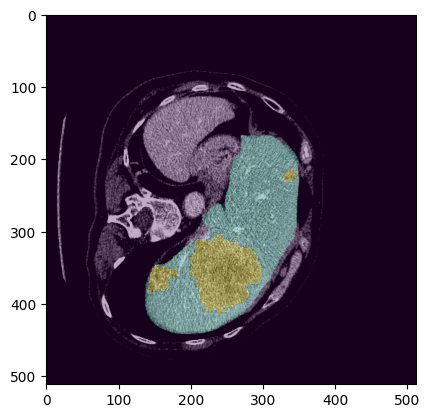

In [12]:
print(inputs.shape)
visualize_data(inputs, labels)

In [13]:
model_cfg = {}
model_cfg["image_size"] = (512, 512)
model_cfg["patch_size"] = 16
model_cfg["d_model"] = 128
model_cfg["n_heads"] = 4
model_cfg["n_layers"] = 4
model_cfg["normalization"] = 'vit'
model_cfg["distilled"] = False
model_cfg["backbone"] = 'custom'
model_cfg["dropout"] = 0.0
model_cfg["drop_path_rate"] = 0.0
model_cfg["n_cls"] = 3
model_cfg["policy_method"] = 'policy_net' #'no_sharing' #
#model_cfg["policy_schedule"] = (1024, 0)
#model_cfg["policy_schedule"] = (512, 128)
model_cfg["policy_schedule"] = (128, 224)
#model_cfg["policy_schedule"] = (64, 240)
model_cfg["policynet_ckpt"] = 'policy_net.pth'
decoder_cfg = {}
decoder_cfg["drop_path_rate"] = 0.0
decoder_cfg["dropout"] = 0.0
decoder_cfg["n_layers"] = 2
decoder_cfg["name"] = 'mask_transformer'
model_cfg["decoder"] = decoder_cfg

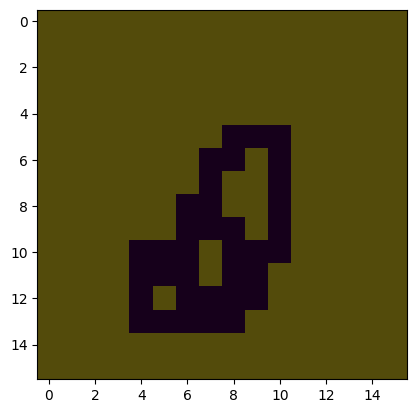

In [14]:
policy_labels = create_policy_labels(labels, model_cfg["patch_size"])
visualize_data(inputs, policy_labels)
#train_policy_net(inputs, policy_labels)

In [15]:
model = create_segmenter(model_cfg)
model.to(device)
print(model)
print("Total parameters: {}".format(count_parameters(model)))
print("Encoder parameters: {}".format(count_parameters(model.encoder)))
print("Decoder parameters: {}".format(count_parameters(model.decoder)))
if model_cfg["policy_method"] == 'policy_net':
    print("Policy net parameters: {}".format(count_parameters(model.policy_net)))

No pretrained weights exist for this model. Using random initialization.
Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Segmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(1, 128, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-3): 4 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (mlp): FeedForward(
          (fc1): Linear(in_features=128, out_features=512, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=512, out_features=128, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
      )
    )
    (norm): L

masks shape: torch.Size([1, 3, 1, 352])
torch.Size([1, 352, 3])
tensor([[[ 1., 10., 16.],
         [ 1., 10., 17.],
         [ 1., 10., 18.],
         ...,
         [ 2., 30., 26.],
         [ 2., 30., 28.],
         [ 2., 30., 30.]]])
masks shape: torch.Size([1, 3, 1, 352])
torch.Size([1, 352, 3])
tensor([[[ 1., 10., 16.],
         [ 1., 10., 17.],
         [ 1., 10., 18.],
         ...,
         [ 2., 30., 26.],
         [ 2., 30., 28.],
         [ 2., 30., 30.]]])
masks shape: torch.Size([1, 3, 1, 352])
torch.Size([1, 352, 3])
tensor([[[ 1., 10., 16.],
         [ 1., 10., 17.],
         [ 1., 10., 18.],
         ...,
         [ 2., 30., 26.],
         [ 2., 30., 28.],
         [ 2., 30., 30.]]])
masks shape: torch.Size([1, 3, 1, 352])
torch.Size([1, 352, 3])
tensor([[[ 1., 10., 16.],
         [ 1., 10., 17.],
         [ 1., 10., 18.],
         ...,
         [ 2., 30., 26.],
         [ 2., 30., 28.],
         [ 2., 30., 30.]]])
masks shape: torch.Size([1, 3, 1, 352])
torch.Size([1, 3

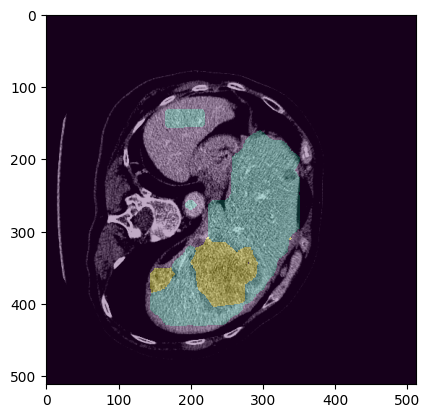

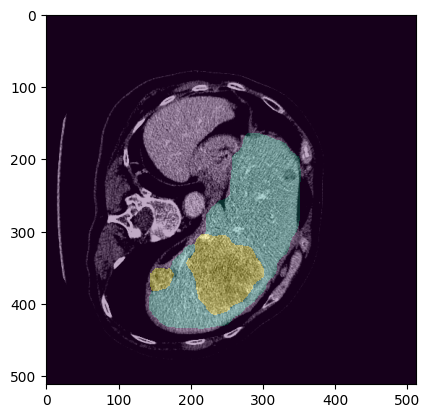

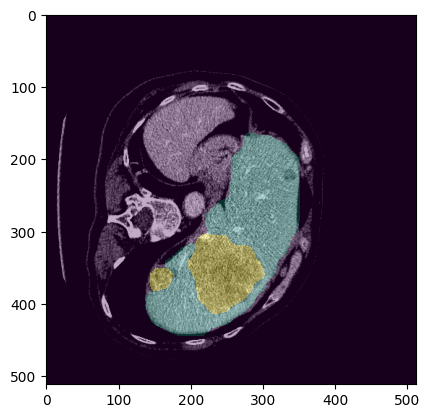

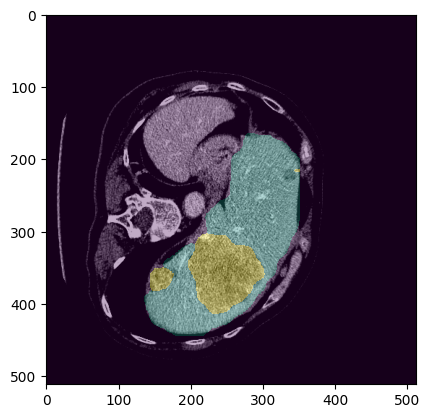

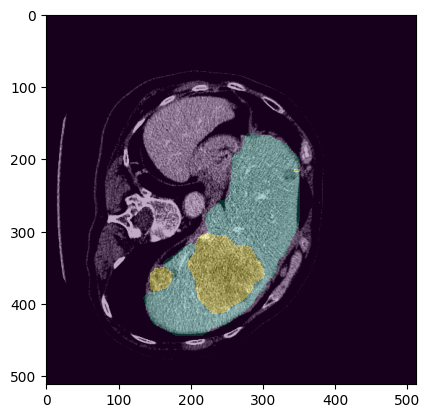

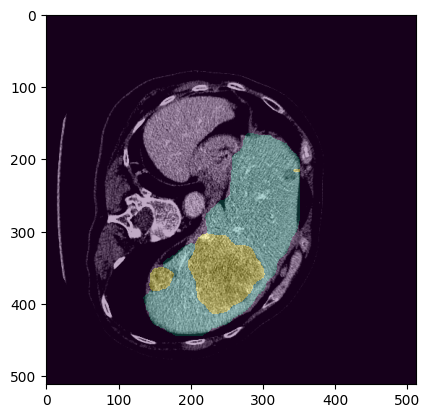

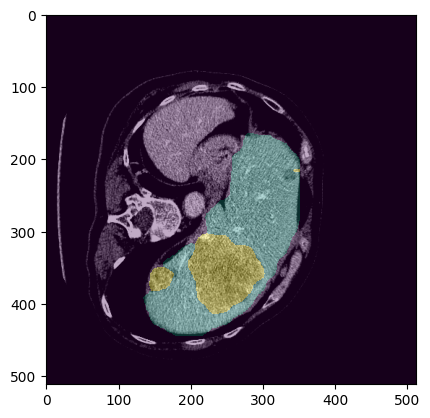

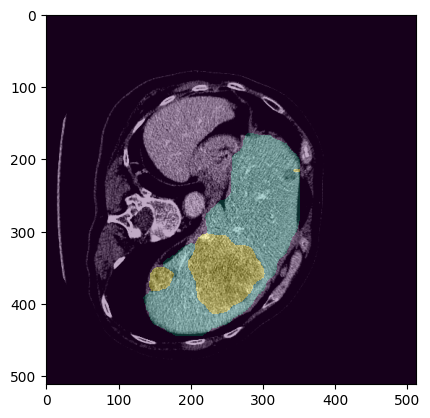

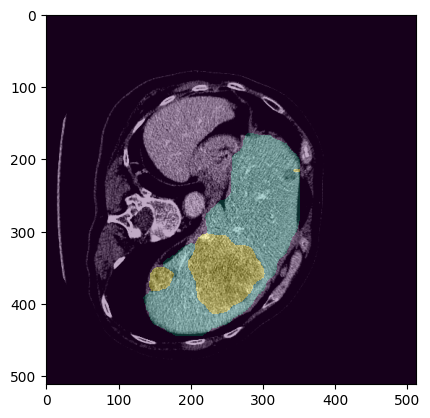

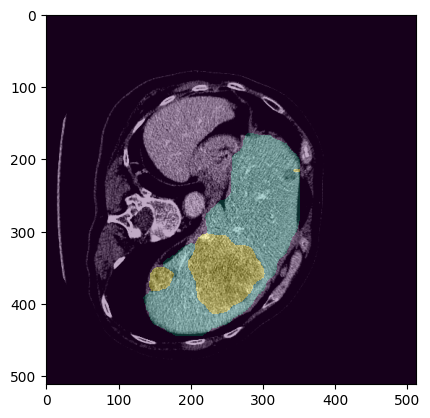

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False)
post_label = monai.transforms.AsDiscrete(to_onehot=3)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=3)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 1000
total_prints = 10
print_every_n_epochs = epochs // total_prints
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


for e in range(epochs):
    outputs, _, _ = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    labels_convert = [post_label(labels[0])]
    output_convert = [post_pred(outputs[0])]
    dice_metric(y_pred=output_convert, y=labels_convert)
    dice_scores, dice_not_nans = dice_metric.aggregate()
    if ((e + 1) % print_every_n_epochs) == 0:
        print("Epoch: {}, Dice score: {}, loss: {}, lr: {}".format(e, dice_scores.item(), loss.item(), scheduler.get_last_lr()))
        pred = torch.argmax(outputs, dim=1)
        visualize_data(inputs, pred)
    scheduler.step()